# Jon Oulton
## Preliminary Route Data Analysis

In [217]:
import numpy as np
import pandas as pd
import json
from matplotlib import pyplot as plt
import string
from datetime import datetime
%matplotlib inline

## EXISTING TO-DO

1) Separate unpacking and munging date into a separate file

2) Create plot of cumulative # of routes added/year, separated by grade

3) Add Bouldering Grades to simple diff list


## Import Route Data

Bring in route data as a pandas dataframe

In [218]:
# DEFINE PATH TO ROUTE DATA HERE
filepath = './Data/routeData.json'

with open(filepath) as file:
    reader = file.read()
    routesDict = dict(json.loads(reader))
    routes = pd.DataFrame.from_dict(routesDict, orient='index')

In [219]:
# CREATE A LIST OF ALL MP GRADES
with open('./Data/grades.txt') as file:
    reader = file.read()
    grades = []
    tempStr = ""
    for c in reader:
        if c != '\n':
            tempStr = tempStr + c
        else:
            grades.append(tempStr)
            tempStr = ""

In [220]:
# FUNCTION TO CONVERT GRADES TO SIMPLE GRADE (E.G. 5.10c/d -> 5.10)
def makeSimpleGrade(routeGrade): # routeGrade is grade to be converted - - - gradeList is list of simpleGrades
    try:   
        simpleGradeList = ['3rd', '4th', 'Easy 5th', '5.0', '5.1', '5.2', '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '5.10', '5.11', '5.12', '5.13', '5.14', '5.15']
    
        # Handle general case
        for simpleGrade in simpleGradeList:
            if simpleGrade in routeGrade and simpleGrade != '5.1': 
                return simpleGrade

        # Handle 5.1 special case
        if routeGrade == "5.1": 
            return '5.1'
    except:
        return None
    
# MODULARIZED TRY/EXCEPT BLOCK TO CONVERT THE STRING DATE TO A DATETIME OBJECT
def convertStrDateToDatetime(stringDate):
    try:
        return datetime.strptime(stringDate, '%b %d, %Y')
    except:
        return None
    
# MODULARIZED TRY/EXCEPT BLOCK TO GET THE YEAR FROM THE DATETIME OBJECT
def getYear(datetimeObj):
    try:
        return int(datetimeObj.year)
    except:
        return None


## Unpack nested JSON objects

In [221]:
routes['latitude'] = [float(routes["location"][item]['latitude']) for item in range(len(routes["location"]))]
routes['longitude'] = [float(routes['location'][item]['longitude']) for item in range(len(routes))]
routes['diffRating'] = [routes['grade'][item]['rateYDS'] for item in range(len(routes))]
routes['avgQualityRating'] = [float(routes['votes'][item]['avgRating']) for item in range(len(routes))]
routes['numQualityVotes'] = [float(routes['votes'][item]['avgRating']) for item in range(len(routes))]
routes['desc_aggregateData'] = [routes['description'][item]['aggregateData'] for item in range(len(routes))]
routes['trad'] = [routes['description'][item]['trad'] for item in range(len(routes))]
routes['sport'] = [routes['description'][item]['sport'] for item in range(len(routes))]
routes['boulder'] = [routes['description'][item]['boulder'] for item in range(len(routes))]
routes['aid'] = [routes['description'][item]['aid'] for item in range(len(routes))]
routes['ice'] = [routes['description'][item]['ice'] for item in range(len(routes))]
routes['mixed'] = [routes['description'][item]['mixed'] for item in range(len(routes))]
routes['alpine'] = [routes['description'][item]['alpine'] for item in range(len(routes))]
routes['TR'] = [routes['description'][item]['TR'] for item in range(len(routes))]
routes['pageViews'] = [routes['pageData'][item]['totalViews'] for item in range(len(routes))]
routes['viewsPerMonth'] = [routes['pageData'][item]['viewsPerMonth'] for item in range(len(routes))]
routes['submittedOn'] = [convertStrDateToDatetime(routes['pageData'][item]['submittedOn']) for item in range(len(routes))]
routes['subYear'] = [getYear(routes['submittedOn'][item]) for item in range(len(routes))]
routes['submittedBy'] = [routes['pageData'][item]['submittedBy'] for item in range(len(routes))]
routes['votePageUrl'] = [routes['urls'][item]['votePage'] for item in range(len(routes))]

# ADD THE LENGTH AND PITCHES
lengthFt = [routes['length'][item]['feet'] for item in range(len(routes))]
pitches = [routes['length'][item]['pitches'] for item in range(len(routes))]

for item in lengthFt:     # CONVERT TO INTS
    try: item = int(item)
    except: item = None
for item in lengthFt:     # CONVERT TO INTS
    try: item = int(item)
    except: item = None
        
routes['lengthFt'] = lengthFt
routes['pitches'] = pitches

# ADD THE BREADCRUMB TRAILS
breadcrumb = [0] * len(routes)
for item in range(len(routes)):
    routeBreadcrumb = [0, []]
    routeBreadcrumb[0] = len(routes['breadcrumb'][item]['itemListElement'])
    for area in range(len(routes['breadcrumb'][item]['itemListElement'])):
        routeBreadcrumb[1].append([routes['breadcrumb'][item]['itemListElement'][area]['position'],
                                   routes['breadcrumb'][item]['itemListElement'][area]['item']['name'],
                                   routes['breadcrumb'][item]['itemListElement'][area]['item']['@id']])
    breadcrumb[item] = routeBreadcrumb

# DROP THE SUPERFULOUS COLUMNS
routes.drop(columns=['pageType', 'urls', 'location', 'grade', 'votes', 'description', 'length', 'pageData', 'textFields', 'breadcrumb'], inplace=True)

## More Data Munging

In [222]:
def stringToList(s, onlyDigits):
    words = []
    currentWord = ""
    counter = 0
    for c in s:
        if c in string.whitespace or c == ",":
            if onlyDigits:
                if currentWord.isdigit():
                    words.append(currentWord)
            else:
                words.append(currentWord)
            currentWord = ""
            counter += 1
        elif counter == len(s)-1:
            currentWord += c
            if onlyDigits:
                if currentWord.isdigit():
                    words.append(currentWord)
            else:
                words.append(currentWord)
            counter += 1
        else:
            currentWord += c
            counter += 1
    return words

# REMOVE "YDS" FROM DIFFICULTY RATING
diff = []
for item in routes['diffRating']:
    diff.append(item)
    
for item in range(len(diff)):
    try:
        if "YDS" in diff[item]:
            s = stringToList(diff[item], 0)
            s = s[:len(s)-1]
            diff[item] = " ".join(s)
    except TypeError:
        continue

# ADD THE DIFF RATINGS (W/O 'YDS') TO THE 'ROUTES' DATAFRAME
routes['diffRating'] = diff

# ADD A COLUMN OF SIMPLE DIFFICULTY RATINGS TO THE 'ROUTES' DATAFRAME (E.G. 5.10c/d -> 5.10)
routes['simpleDiffRating'] = [makeSimpleGrade(routes['diffRating'][item]) for item in range(len(routes))]

# DROP ALL ROWS WITH NULL VALUES
routes = routes.dropna()

## Basic Analytics

In [223]:
print("Total number of routes:", len(routes))
print("Number of trad routes:", len(routes.loc[routes['trad'] == True]))
print("Number of sport routes:", len(routes.loc[routes['sport'] == True]))
print("Percent of routes marked as both sport and trad: {:.2f}".format((len(routes.loc[(routes['trad'] == True) & (routes['sport'] == True)])/len(routes))*100),"%")
set(routes['diffRating'])

trad = routes.loc[(routes['trad'] == True) & (routes['sport'] == False)]['diffRating'].dropna()
sport = routes.loc[(routes['trad'] == False) & (routes['sport'] == True)]['diffRating'].dropna()

Total number of routes: 14080
Number of trad routes: 11508
Number of sport routes: 2867
Percent of routes marked as both sport and trad: 3.71 %


In [224]:
# GATHER QUANTITY OF EACH ROUTE INTO PRE-DEFINED ROUTE BINS 
tradDistro = []
for i in grades:
    tradDistro.append(np.sum(trad == i))

sportDistro = []
for i in grades:
    sportDistro.append(np.sum(sport == i))

# CONVERT MULTIPLE GRADES TO SIMPLE GRADES (e.g. 5.10-/5.10a/5.10c => 5.10)
simpleGrades = ['3rd', '4th', 'Easy 5th', '5.0', '5.1', '5.2', '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '5.10', '5.11', '5.12', '5.13', '5.14', '5.15']
simpleTrad = [0] * len(simpleGrades)
simpleSport = [0] * len(simpleGrades)
for i in range(len(simpleGrades)):
    for j in range(len(grades)):
        if simpleGrades[i] in grades[j] and simpleGrades[i] != '5.1':
            simpleTrad[i] = simpleTrad[i] + tradDistro[j]
            simpleSport[i] = simpleSport[i] + sportDistro[j]
        elif simpleGrades[i] is '5.1' and grades[j] == '5.1':
            simpleTrad[i] = simpleTrad[i] + tradDistro[j]
            simpleSport[i] = simpleSport[i] + sportDistro[j]
            


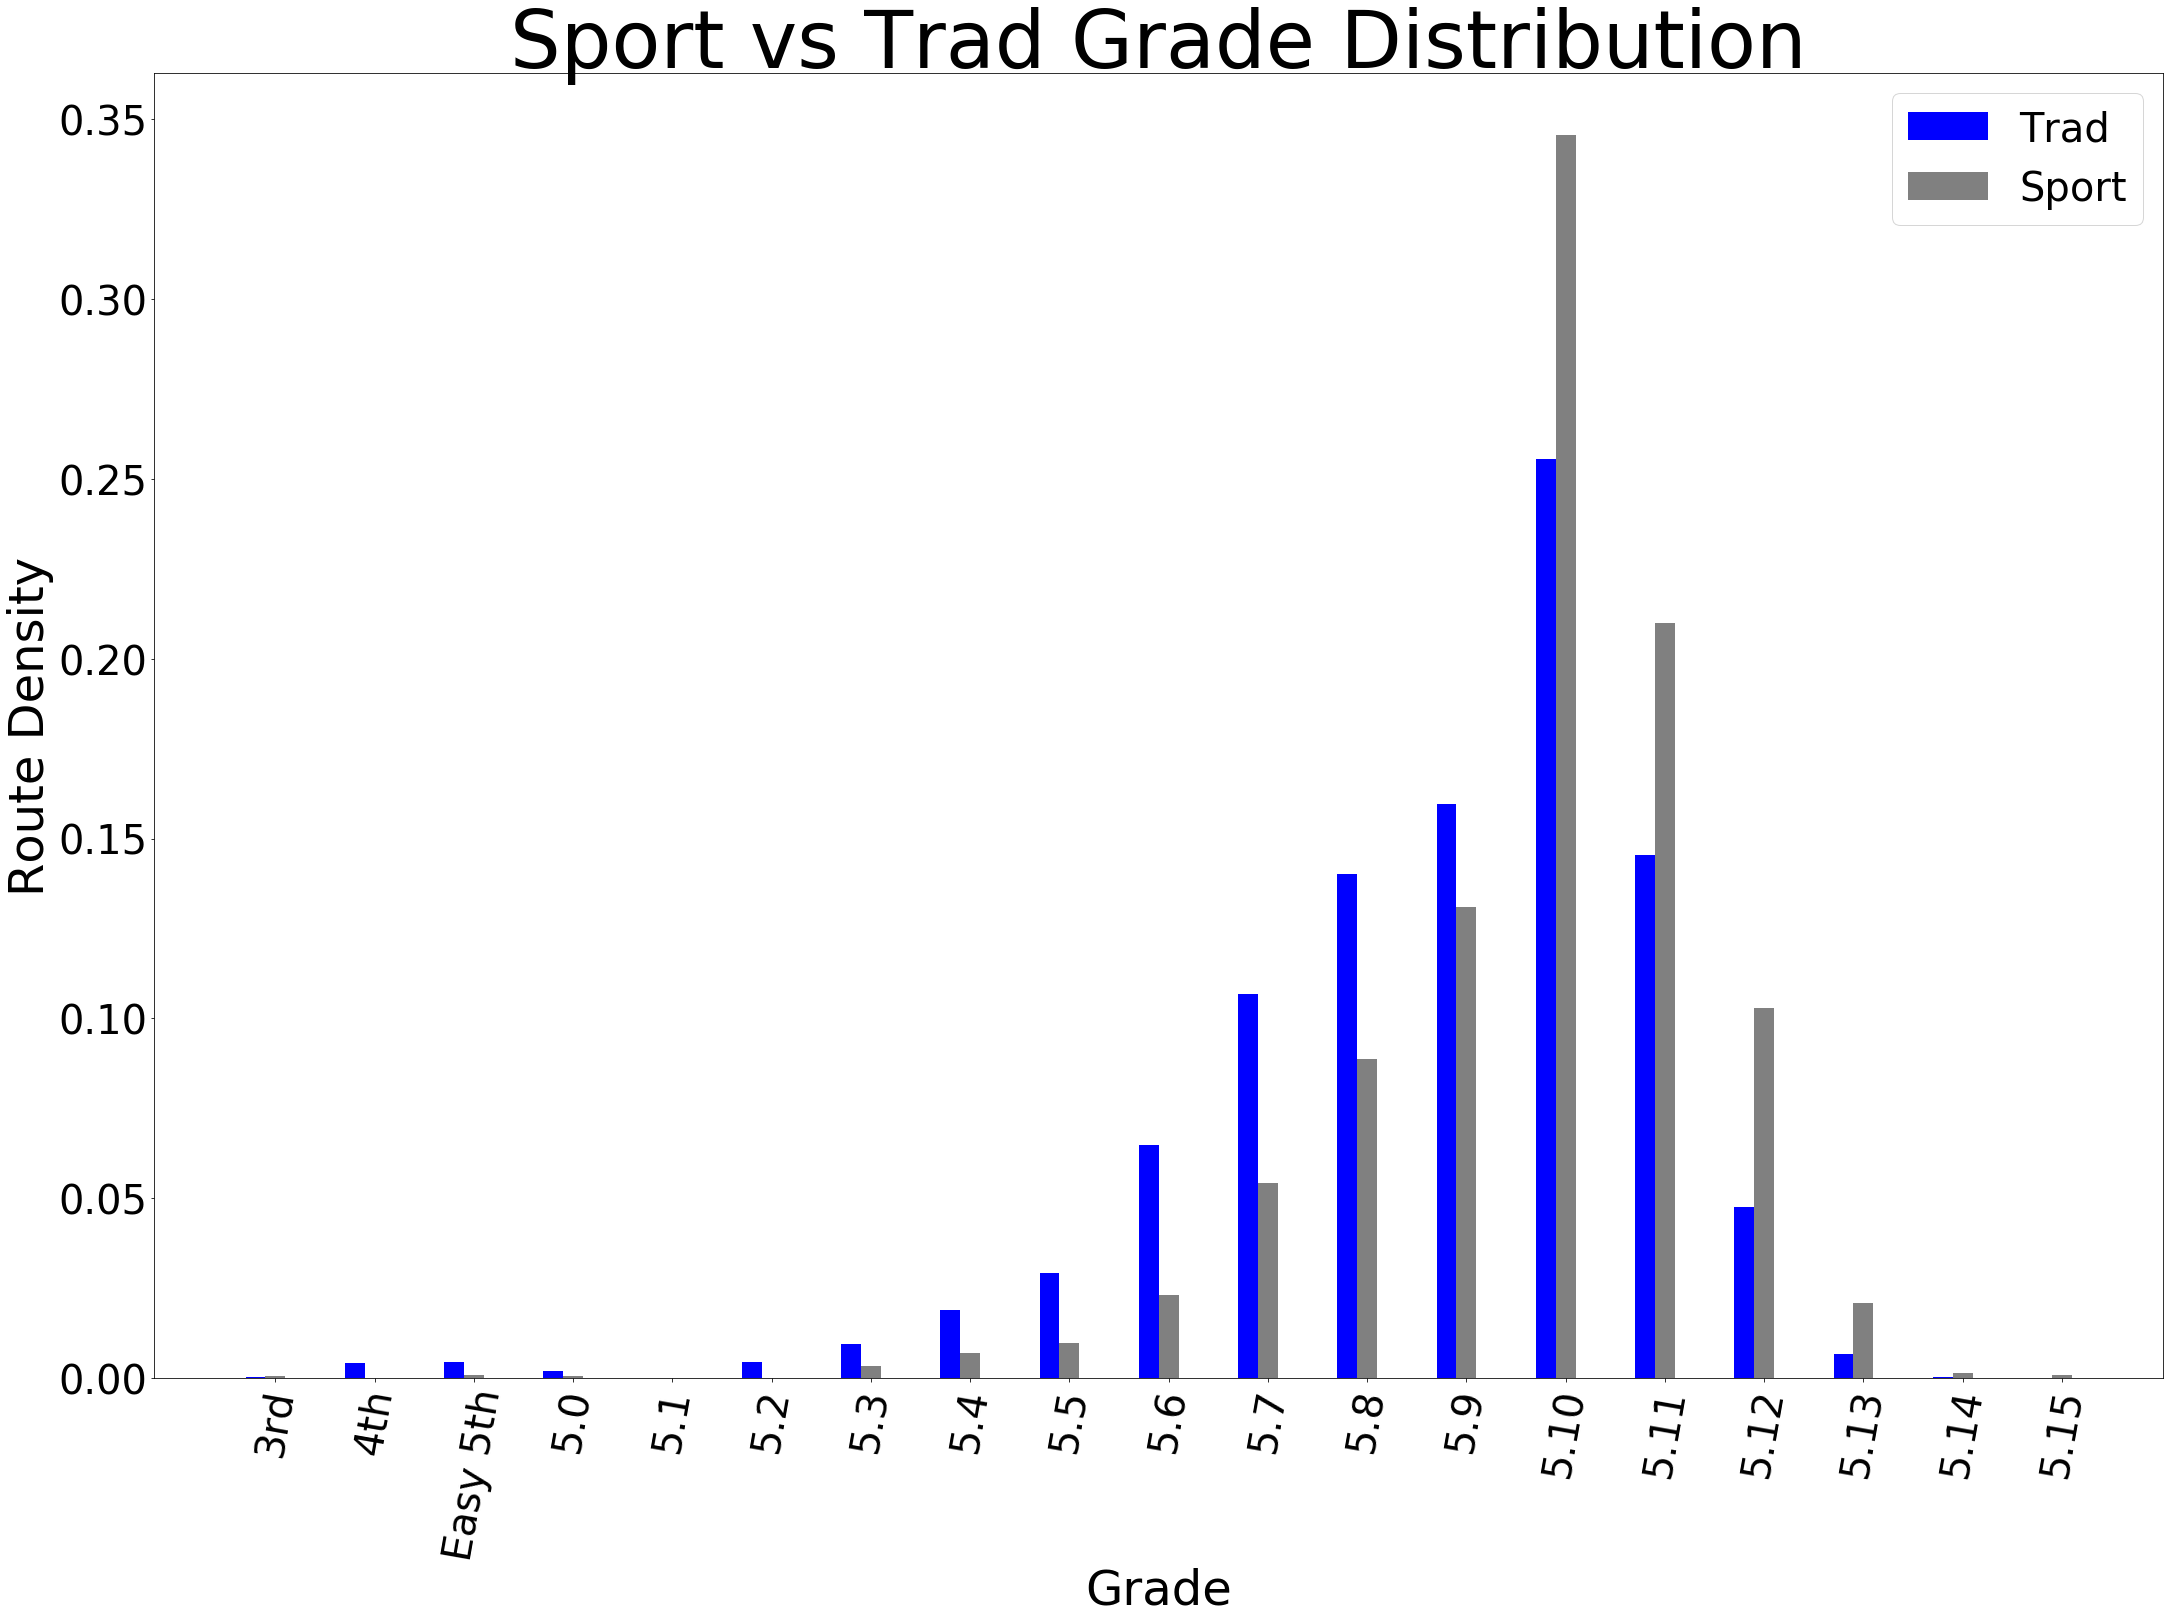

In [225]:
# CHANGE THESE TO ALTER GRAPH (EXPANDED VS COMPRESSED GRADES)
tradBars = simpleTrad   # CHANGE BTW SIMPLETRAD & TRAD DISTRO
sportBars = simpleSport # CHANGE BTW SIMPLESPORT & SPORT DISTRO
labels = simpleGrades   # CHANGE BTW SIMPLEGRADES & GRADES

# NORMALIZE THE DATA
normTrad = []
for i in tradBars:
    normTrad.append(i/np.sum(tradBars))
normSport = []
for i in sportBars:
    normSport.append(i/np.sum(sportBars))
    
# PLOT THE FIGURE
fig, ax = plt.subplots(figsize=(36,24))
ind = np.arange(len(labels))
width = 0.2
ax.bar(ind-(width/2), normTrad, width=width, tick_label=labels, color='blue')
ax.bar(ind+(width/2), normSport, width=width, tick_label=labels, color='grey')
ax.set_xlabel("Grade", fontsize=48)
ax.set_ylabel("Route Density", fontsize=48)
ax.set_title("Sport vs Trad Grade Distribution", fontsize=80)
ax.tick_params(axis='x', labelrotation=80, labelsize=40)
ax.tick_params(axis='y', labelsize=40)
ax.legend(["Trad", "Sport"], fontsize=40)

fig.savefig('Figures/sportVsTrad.png')

plt.show()

***

***

# Examining Number of Routes Submitted Per Year

#### The following section examines the number of routes that are submitted to Mountain Project by year. Further, it is split up by grade.

#### In this way, we seek to explore how different populations of grades grew on the site over time.

#### First, we consider the probability mass function (pmf) of each routes per year (per grade). Next we consider the cumulative distribution function (cdf) of these same routes.

***
### Step #1: Organizing the Data

#### Here, we create a list of lists, called "routesPerYear_Grade". Each sub-list represents a grade. Each item within a sublist represents the number of routes added per year for that grade.

#### The "routesPerYear_Total" list is the cumulative number of routes added per year, regardless of grade

In [226]:
# CREATE LIST OF UNIQUE SUBMISSION YEAR VALUES AND SORT THEM
sortedYears = sorted(routes.subYear.unique())
print(sortedYears)

# GET DISCRETE NUMBER OF ROUTES ADDED IN 'X' YEAR, DIVIDED BY GRADE
routesPerYear_Grade = [[np.sum((routes['subYear']==year) & (routes['simpleDiffRating']==grade)) for year in sortedYears] for grade in simpleGrades]

# GET DISCRETE NUMBER OF ROUTES ADDED IN 'X' YEAR, DIVIDED BY GRADE
routesPerYear_Grade = [[np.sum((routes['subYear']==year) & (routes['simpleDiffRating']==grade)) for grade in simpleGrades] for year in sortedYears]

# GET DISCRETE NUMBER OF ROUTES ADDED IN 'X' YEAR ONLY (GRADE NOT CONSIDERED)
routesPerYear_Total = [np.sum(routes['subYear']==year) for year in sortedYears]

"""
~~~~~
The following code block is the antiquated method to build the list of lists.
~~~~~

total = []
for year in sortedYears:
    total.append(np.sum(routes['subYear']==year))
routesPerYear.append(total)
print(routesPerYear)
# GET DISCRETE NUMBER OF ROUTES PER GRADE PER YEAR
for grade in range(1, len(simpleGrades)):
    numRoutesAddedPerYear = []
    for year in sortedYears:
        numRoutesAddedPerYear.append(np.sum((routes['subYear']==year) & (routes['simpleDiffRating']==simpleGrades[grade])))
    routesPerYear.append(numRoutesAddedPerYear)
"""
        

[2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0]


"\n~~~~~\nThe following code block is the antiquated method to build the list of lists.\n~~~~~\n\ntotal = []\nfor year in sortedYears:\n    total.append(np.sum(routes['subYear']==year))\nroutesPerYear.append(total)\nprint(routesPerYear)\n# GET DISCRETE NUMBER OF ROUTES PER GRADE PER YEAR\nfor grade in range(1, len(simpleGrades)):\n    numRoutesAddedPerYear = []\n    for year in sortedYears:\n        numRoutesAddedPerYear.append(np.sum((routes['subYear']==year) & (routes['simpleDiffRating']==simpleGrades[grade])))\n    routesPerYear.append(numRoutesAddedPerYear)\n"

### Step #2: Graphing the Data

#### Here, we plot the pmf and cdf onto line plots to see how different grade populations grew with time on MP.com.

In [227]:
for i in range(len(routesPerYear_Grade)):
    print(routesPerYear_Grade[i], sortedYears[i])

[0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 10, 7, 5, 6, 7, 3, 0, 0, 0] 2000.0
[0, 2, 0, 2, 0, 3, 2, 6, 9, 7, 19, 17, 23, 22, 19, 7, 0, 0, 0] 2001.0
[0, 1, 0, 3, 3, 6, 1, 8, 11, 10, 29, 32, 35, 59, 53, 13, 1, 0, 0] 2002.0
[0, 1, 0, 0, 0, 1, 0, 0, 1, 19, 22, 25, 53, 64, 50, 10, 0, 0, 0] 2003.0
[0, 0, 0, 0, 0, 0, 3, 4, 8, 9, 33, 54, 60, 93, 45, 11, 2, 0, 0] 2004.0
[0, 0, 0, 0, 0, 1, 1, 1, 2, 12, 17, 34, 17, 43, 23, 8, 1, 0, 0] 2005.0
[0, 1, 1, 0, 0, 2, 8, 28, 32, 64, 98, 127, 171, 254, 119, 19, 2, 0, 0] 2006.0
[0, 0, 3, 0, 0, 3, 7, 15, 21, 67, 123, 150, 178, 320, 164, 51, 6, 0, 0] 2007.0
[0, 3, 2, 0, 0, 2, 5, 6, 17, 52, 80, 137, 148, 247, 174, 75, 13, 3, 0] 2008.0
[0, 3, 6, 0, 1, 1, 10, 14, 34, 60, 96, 120, 159, 249, 147, 63, 10, 0, 0] 2009.0
[0, 1, 3, 0, 0, 0, 4, 9, 22, 41, 80, 108, 124, 247, 137, 51, 10, 0, 0] 2010.0
[0, 1, 3, 0, 0, 4, 3, 12, 23, 33, 92, 107, 147, 240, 97, 39, 7, 1, 0] 2011.0
[0, 3, 1, 0, 0, 4, 5, 18, 20, 41, 94, 117, 127, 291, 164, 52, 7, 0, 0] 2012.0
[1, 11, 3, 7, 1, 3, 8, 15, 20

In [228]:
print("Length of years is:", len(sortedYears))
print("Length of grades is:", len(simpleGrades))

Length of years is: 20
Length of grades is: 19


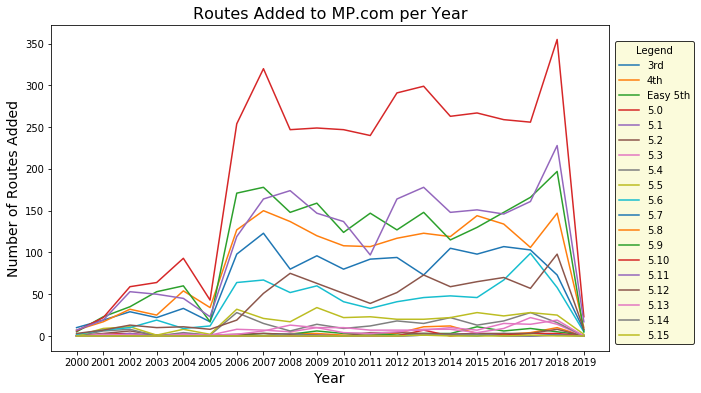

In [231]:
fig, ax = plt.subplots(figsize=(10,6))

# PLOT THE DATA (X=YEARS, Y=ROUTES_PER_YEAR)
ax.plot(sortedYears, routesPerYear_Grade)
# ax.plot(sortedYears, routesPerYear_Total)

# FORMAT THE GRAPH
ax.set_title("Routes Added to MP.com per Year", fontsize=16)
ax.set_ylabel("Number of Routes Added", fontsize=14)
ax.set_xlabel("Year", fontsize=14)
ax.legend(simpleGrades, loc=(1.01, 0.02), title="Legend", edgecolor='k', facecolor='lightgoldenrodyellow')
ax.set_xticks(sortedYears)

fig.savefig('Figures/routesAddedPerYear.png')

plt.show()

### Make a cumulative graph

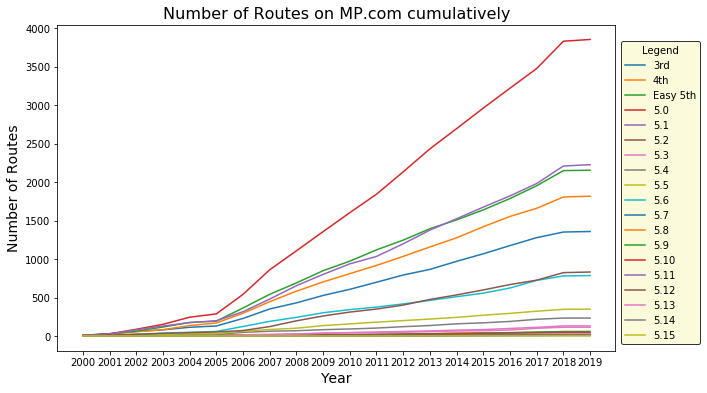

In [233]:
routesPerYear_Cumulative = [[np.sum((routes['subYear']<=year) & (routes['simpleDiffRating']==grade)) for grade in simpleGrades] for year in sortedYears]

fig, ax = plt.subplots(figsize=(10,6))

# PLOT THE DATA (X=YEARS, Y=ROUTES_PER_YEAR)
ax.plot(sortedYears, routesPerYear_Cumulative)
# ax.plot(sortedYears, routesPerYear_Total)

# FORMAT THE GRAPH
ax.set_title("Number of Routes on MP.com cumulatively", fontsize=16)
ax.set_ylabel("Number of Routes", fontsize=14)
ax.set_xlabel("Year", fontsize=14)
ax.legend(simpleGrades, loc=(1.01, 0.02), title="Legend", edgecolor='k', facecolor='lightgoldenrodyellow')
ax.set_xticks(sortedYears)

fig.savefig('Figures/cumulativeRoutes.png')

plt.show()